<a href="https://colab.research.google.com/github/Tommy-Las/WatfordFC/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import defaultdict
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression

In [2]:
file_path = 'data/cleaned_data_no_injured.xlsx'
#file_path = 'data/cleaned_data_no_injured_3.xlsx'
# Load the CSV into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
df.head()

,DATE,Microcycle,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,...,>25-21,ACC-21,DEC-21,Sprints-21,Mins-21,Position_CENTREBACK,Position_CENTREMIDFIELDER,Position_FULLBACK,Position_STRIKER,Position_WINGER
0,2021-08-11,M-3,0,2021-2022,SEASON,7423.0,426.0,20,52.0,38.0,...,34,63.0,36.0,19,80.35,0,1,0,0,0
1,2021-08-12,M-2,0,2021-2022,SEASON,1268.0,0.0,0,11.0,5.0,...,54,115.0,74.0,43,171.20,0,1,0,0,0
2,2021-08-13,M-1,0,2021-2022,SEASON,4135.0,112.0,2,47.0,20.0,...,54,126.0,79.0,43,214.78,0,1,0,0,0
3,2021-08-15,M+1,0,2021-2022,SEASON,6379.0,86.0,0,49.0,48.0,...,56,173.0,99.0,54,273.13,0,1,0,0,0
4,2021-08-17,M-4,0,2021-2022,SEASON,6287.0,209.0,9,62.0,44.0,...,56,222.0,147.0,67,352.61,0,1,0,0,0


In [3]:
test = df[df['PlayerID'] == 37990].sort_values(by='DATE', ascending=False)
test.head()

,DATE,Microcycle,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,...,>25-21,ACC-21,DEC-21,Sprints-21,Mins-21,Position_CENTREBACK,Position_CENTREMIDFIELDER,Position_FULLBACK,Position_STRIKER,Position_WINGER
2706,2023-05-07,M-1,0,2022-2023,SEASON,2239.0,35.0,0,36.0,17.0,...,866,808.0,631.0,254,973.60,0,0,1,0,0
2705,2023-05-06,M-2,0,2022-2023,SEASON,4621.0,140.0,41,73.0,50.0,...,1114,821.0,686.0,297,1008.18,0,0,1,0,0
2704,2023-05-05,M-3,0,2022-2023,SEASON,2863.0,111.0,10,40.0,30.0,...,1120,807.0,679.0,293,1027.80,0,0,1,0,0
2703,2023-05-03,M-5,0,2022-2023,SEASON,4768.0,356.0,138,69.0,53.0,...,1041,814.0,687.0,287,1030.52,0,0,1,0,0
2702,2023-05-02,M+3,0,2022-2023,SEASON,4732.0,145.0,4,72.0,53.0,...,1037,742.0,634.0,273,961.22,0,0,1,0,0


Class imbalance:

In [4]:
print("No Lesión: " + str(df[df["Injury"] == 0].shape[0]))
print("Lesión: " + str(df[df["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df[df['Injury'] == 1].shape[0] / df.shape[0]) * 100):.2f}%")

No Lesión: 4398
Lesión: 36
Porcentaje de lesionados en el dataset: 0.81%


# Correlation of variables

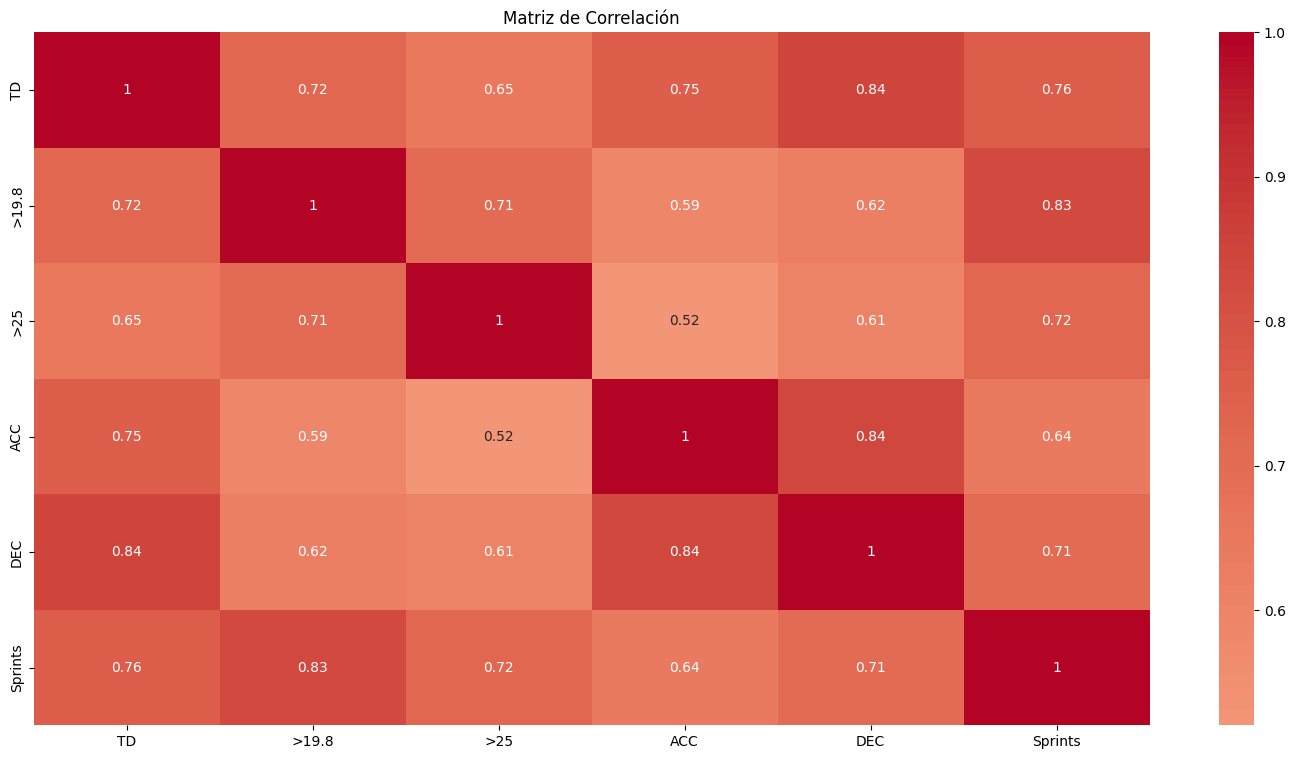

In [10]:
metrics = ['TD', '>19.8',
       '>25', 'ACC', 'DEC', 'Sprints']

# Calcular la matriz de correlación
correlation_matrix = df[metrics].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


In [11]:
df_with_constant = add_constant(df[metrics])

# Calcular el VIF para cada columna
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                   for i in range(df_with_constant.shape[1])]

# Mostrar el VIF
print(vif_data)

  Variable       VIF
0    const  7.536370
1       TD  4.628723
2    >19.8  3.719300
3      >25  2.396270
4      ACC  3.594287
5      DEC  5.476943
6  Sprints  4.365045


# Filter data by date or season


In [5]:
# Season 2022-2023
df_filtered = df[df['season']=='2022-2023']

# Season 2021-2022
# df_filtered = df[df['season']=='2021-2022']

# Filter by no season
# df_filtered = df.copy()

df_filtered.head()

,DATE,Microcycle,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,...,>25-21,ACC-21,DEC-21,Sprints-21,Mins-21,Position_CENTREBACK,Position_CENTREMIDFIELDER,Position_FULLBACK,Position_STRIKER,Position_WINGER
134,2022-06-21,NaN,0,2022-2023,PRESEASON,5511.0,113.0,6,68.0,35.0,...,1,57.0,21.0,15,81.69,0,1,0,0,0
135,2022-06-22,NaN,0,2022-2023,PRESEASON,6553.0,27.0,0,96.0,34.0,...,7,125.0,56.0,23,154.86,0,1,0,0,0
136,2022-06-23,NaN,0,2022-2023,PRESEASON,13058.0,267.0,17,90.0,63.0,...,7,221.0,90.0,26,249.01,0,1,0,0,0
137,2022-06-24,NaN,0,2022-2023,PRESEASON,6716.0,232.0,33,75.0,45.0,...,24,311.0,153.0,40,327.12,0,1,0,0,0
138,2022-06-25,NaN,0,2022-2023,PRESEASON,7723.0,241.0,45,54.0,46.0,...,57,386.0,198.0,53,395.66,0,1,0,0,0


In [6]:
df_filtered = df_filtered[df_filtered['preseason-season'] != 'PRESEASON']

df_filtered.reset_index(drop=True, inplace=True)

In [7]:
print("No Lesión: " + str(df_filtered[df_filtered["Injury"] == 0].shape[0]))
print("Lesión: " + str(df_filtered[df_filtered["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df_filtered[df_filtered['Injury'] == 1].shape[0] / df_filtered.shape[0]) * 100):.2f}%")

No Lesión: 2289
Lesión: 23
Porcentaje de lesionados en el dataset: 0.99%


# ML Models

## Separate data into X, y and player_ids

In [8]:
df_filtered.columns

Index(['DATE', 'Microcycle', 'Injury', 'season', 'preseason-season', 'TD',
       '>19.8', '>25', 'ACC', 'DEC', 'PlayerID', 'Max Speed', 'Sprints',
       'Mins', 'Max Speed Season', 'Avg Speed Season', '% Max Speed',
       'Speed Diff Max Avg', 'TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1',
       'Sprints-1', 'Mins-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
       'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
       'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21', 'Mins-21', 'Position_CENTREBACK',
       'Position_CENTREMIDFIELDER', 'Position_FULLBACK', 'Position_STRIKER',
       'Position_WINGER'],
      dtype='object')

Initialize the features we want to train

In [9]:
metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1',
       'Sprints-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
       'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
       'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21']

print(len(metrics_train))

25


Sort the df by date

In [10]:
df_sorted = df_filtered.sort_values(by='DATE', ascending=False).reset_index(drop=True)

## Split data

We want to also store the 'DATE' & 'PlayerID' columns for later comparison

### Split by first %X for validating and rest for training

In [11]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Determine the split index for X% testing
percentage_validation = 0.3
split_index = int(percentage_validation * len(df_sorted))

# Split the data
X_test = X.iloc[:split_index].reset_index(drop=True)
X_train = X.iloc[split_index:].reset_index(drop=True)
y_test = y.iloc[:split_index].reset_index(drop=True)
y_train = y.iloc[split_index:].reset_index(drop=True)
extra_cols_test = extra_cols.iloc[:split_index].reset_index(drop=True)
extra_cols_train = extra_cols.iloc[split_index:].reset_index(drop=True)

Select less amount of data

In [12]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 1599
Lesión: 20
Porcentaje de lesionados en el dataset: 1.24%


In [167]:
# Sort X_train by index
X_train = X_train.sort_index()  # Sort by date or relevant index if not already sorted.
y_train = y_train.sort_index()  # Ensure y_train matches X_train in order.

# Filter rows where 'Injury' == 1
injury_rows = X_train[X_train['Injury'] == 1]

# Get 30 days before each injury
# Assuming a datetime index, otherwise adjust for your date representation
indices_to_include = set(injury_rows.index)

for idx in injury_rows.index:
    # Include 30 rows before the 'Injury == 1', ensure not out of bounds
    start_idx = max(0, idx - 30)
    indices_to_include.update(range(start_idx, idx + 1))

# Create a dataframe with required rows (Injury == 1 and 30 days before)
selected_rows = X_train.loc[list(indices_to_include)]
selected_y = y_train.loc[selected_rows.index]  # Match y_train with selected rows

# Get the remaining rows not in `selected_rows`
remaining_rows = X_train.drop(selected_rows.index)
remaining_y = y_train.drop(selected_y.index)

# Proportion for sampling (e.g., 50%)
sample_proportion = 0.5
n_to_sample = int(len(X_train) * sample_proportion - len(selected_rows))

# Randomly sample from the remaining rows
sampled_rows = remaining_rows.sample(n=n_to_sample, random_state=42)
sampled_y = remaining_y.loc[sampled_rows.index]

# Combine the selected rows and sampled rows
X_train = pd.concat([selected_rows, sampled_rows]).sort_index().reset_index(drop=True)
y_train = pd.concat([selected_y, sampled_y]).sort_index().reset_index(drop=True)


In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1619 entries, 0 to 1618
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Injury      1619 non-null   int64  
 1   TD-1        1619 non-null   float64
 2   >19.8-1     1619 non-null   int64  
 3   >25-1       1619 non-null   int64  
 4   ACC-1       1619 non-null   float64
 5   DEC-1       1619 non-null   float64
 6   Sprints-1   1619 non-null   int64  
 7   TD-3        1619 non-null   float64
 8   >19.8-3     1619 non-null   float64
 9   >25-3       1619 non-null   int64  
 10  ACC-3       1619 non-null   float64
 11  DEC-3       1619 non-null   float64
 12  Sprints-3   1619 non-null   int64  
 13  TD-7        1619 non-null   float64
 14  >19.8-7     1619 non-null   float64
 15  >25-7       1619 non-null   int64  
 16  ACC-7       1619 non-null   float64
 17  DEC-7       1619 non-null   float64
 18  Sprints-7   1619 non-null   int64  
 19  TD-21       1619 non-null  

In [14]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 1599
Lesión: 20
Porcentaje de lesionados en el dataset: 1.24%


In [15]:
X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

### Split random 

In [13]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Split the data into training and test sets
# X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.3, random_state=42)

X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
extra_cols_train.reset_index(drop=True, inplace=True)
extra_cols_test.reset_index(drop=True, inplace=True)


## SMOTE or SMOTEEN oversampling technique

In [16]:
# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_train , y_train = smote.fit_resample(X_train, y_train)

# smote_enn = SMOTEENN(random_state=42)
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
Injury
0    1599
1    1599
Name: count, dtype: int64
Injury
0    1599
1    1599
Name: count, dtype: int64


## Logistic Regression

Initialize logistic regression and normalize the data

In [17]:
# Create the model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression Active learning 

to dynamically select data

In [48]:
# Initialize datasets
X_all = X_train_scaled  # Scaled features
y_all = y_train.values  # Labels

# Start with a small labeled dataset from the bottom of the sorted DataFrame
initial_samples = 2000  # Number of initial samples
X_train_active = X_all[-initial_samples:]  # Select the last `initial_samples` rows
y_train_active = y_all[-initial_samples:]  # Corresponding labels

# Remaining unlabeled pool (everything except the selected rows)
X_pool = X_all[:-initial_samples]
y_pool = y_all[:-initial_samples]

print(f"Initial training set size: {len(X_train_active)}")
print(f"Remaining pool size: {len(X_pool)}")

Initial training set size: 2000
Remaining pool size: 1600


Iteration 1/100:
Training Recall for Label 1: 0.7486
Training Size: 2010
Iteration 2/100:
Training Recall for Label 1: 0.7474
Training Size: 2020
Iteration 3/100:
Training Recall for Label 1: 0.7463
Training Size: 2030
Iteration 4/100:
Training Recall for Label 1: 0.7497
Training Size: 2040
Iteration 5/100:
Training Recall for Label 1: 0.7486
Training Size: 2050
Iteration 6/100:
Training Recall for Label 1: 0.7520
Training Size: 2060
Iteration 7/100:
Training Recall for Label 1: 0.7504
Training Size: 2070
Iteration 8/100:
Training Recall for Label 1: 0.7561
Training Size: 2080
Iteration 9/100:
Training Recall for Label 1: 0.7539
Training Size: 2090
Iteration 10/100:
Training Recall for Label 1: 0.7527
Training Size: 2100
Iteration 11/100:
Training Recall for Label 1: 0.7527
Training Size: 2110
Iteration 12/100:
Training Recall for Label 1: 0.7561
Training Size: 2120
Iteration 13/100:
Training Recall for Label 1: 0.7586
Training Size: 2130
Iteration 14/100:
Training Recall for Label 1: 

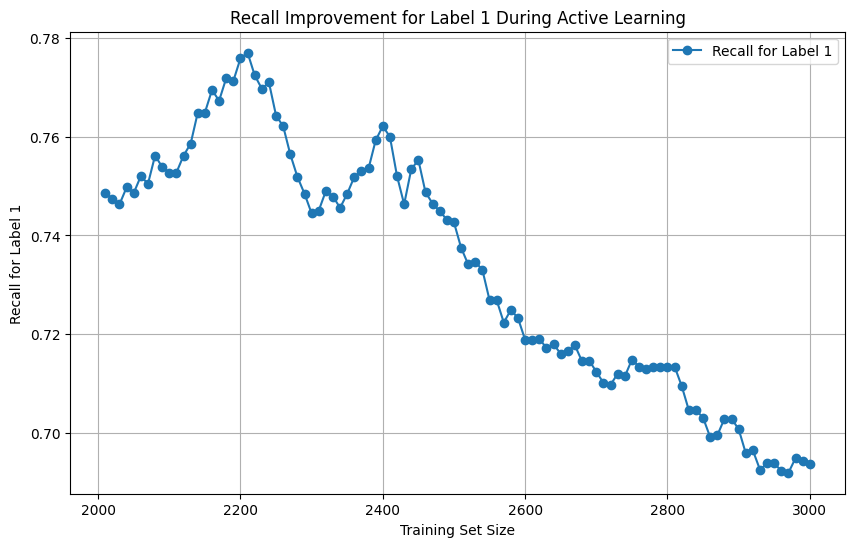

In [49]:
# Parameters for active learning
n_iterations = 100  # Number of active learning iterations
samples_per_iteration = 10  # Samples to add in each iteration

# To store metrics for visualization
train_recall_label1_scores = []
train_sizes = []

for i in range(n_iterations):
    # Train the model on the current labeled dataset
    logistic_model.fit(X_train_active, y_train_active)
    
    # Predict probabilities for the unlabeled pool
    probs = logistic_model.predict_proba(X_pool)[:, 1]
    
    # Find the most uncertain samples (probabilities closest to 0.5)
    uncertainty = np.abs(probs - 0.5)  # Uncertainty measure
    uncertain_indices = np.argsort(uncertainty)[:samples_per_iteration]
    
    # Add the most uncertain samples to the training set
    X_train_active = np.vstack((X_train_active, X_pool[uncertain_indices]))
    y_train_active = np.hstack((y_train_active, y_pool[uncertain_indices]))
    
    # Remove these samples from the pool
    X_pool = np.delete(X_pool, uncertain_indices, axis=0)
    y_pool = np.delete(y_pool, uncertain_indices, axis=0)
    
    # Evaluate recall for label 1
    y_train_pred = logistic_model.predict(X_train_active)
    recall_label1 = recall_score(y_train_active, y_train_pred, pos_label=1)  # Focus on label 1
    train_recall_label1_scores.append(recall_label1)
    train_sizes.append(len(y_train_active))
    
    print(f"Iteration {i + 1}/{n_iterations}:")
    print(f"Training Recall for Label 1: {recall_label1:.4f}")
    print(f"Training Size: {len(y_train_active)}")
    
    
# Plot recall improvement for label 1
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_recall_label1_scores, marker='o', label="Recall for Label 1")
plt.xlabel("Training Set Size")
plt.ylabel("Recall for Label 1")
plt.title("Recall Improvement for Label 1 During Active Learning")
plt.legend()
plt.grid()
plt.show()

In [80]:
# Evaluate on test data
y_test_pred = logistic_model.predict(X_test_scaled)
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))



Test Set Evaluation:
Accuracy: 0.8700947225981055
Confusion Matrix:
 [[643  93]
 [  3   0]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93       736
           1       0.00      0.00      0.00         3

    accuracy                           0.87       739
   macro avg       0.50      0.44      0.47       739
weighted avg       0.99      0.87      0.93       739



### Regular logistic regression

In [18]:
# Train the model
logistic_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)

# Probabilities
y_test_probs = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Training evaluation
print("Training Set Evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# Test evaluation
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Training Set Evaluation:
Accuracy: 0.8095684803001876
Confusion Matrix:
 [[1195  404]
 [ 205 1394]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.80      1599
           1       0.78      0.87      0.82      1599

    accuracy                           0.81      3198
   macro avg       0.81      0.81      0.81      3198
weighted avg       0.81      0.81      0.81      3198


Test Set Evaluation:
Accuracy: 0.6926406926406926
Confusion Matrix:
 [[480 210]
 [  3   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.70      0.82       690
           1       0.00      0.00      0.00         3

    accuracy                           0.69       693
   macro avg       0.50      0.35      0.41       693
weighted avg       0.99      0.69      0.81       693



Find the best threshold

In [19]:
# Thresholds to evaluate (from 0.3 to 0.6 in steps of 0.01)
thresholds = np.arange(0.3, 0.61, 0.01)  # Thresholds from 0 to 1 in steps of 0.01

# Store results
results = []

for threshold in thresholds:
    # Generate predictions for the current threshold
    y_pred = (y_test_probs >= threshold).astype(int)
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append metrics and threshold to results
    results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'Accuracy': accuracy
    })
    
results_df = pd.DataFrame(results)

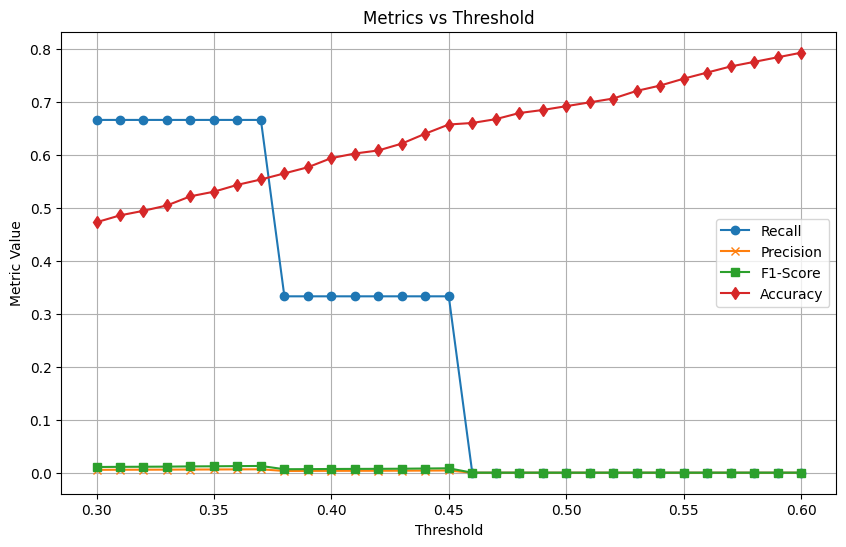

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='x')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='s')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='d')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid()
plt.show()


ROC Curve with manually selecting the threshold

Number of unique thresholds: 9

Manually Selected Threshold: 0.52

Evaluation with Manually Selected Threshold:
Accuracy: 0.7070707070707071
Confusion Matrix:
 [[490 200]
 [  3   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.71      0.83       690
           1       0.00      0.00      0.00         3

    accuracy                           0.71       693
   macro avg       0.50      0.36      0.41       693
weighted avg       0.99      0.71      0.82       693



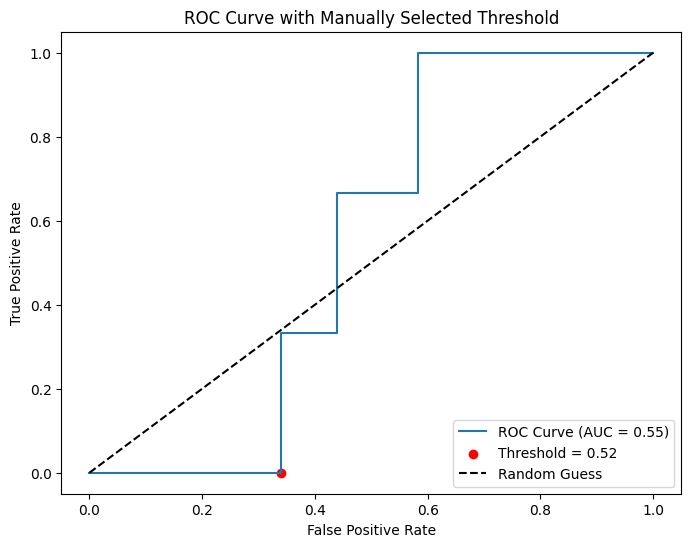

In [21]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

# Print the number of unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Manually select the threshold
manual_threshold = 0.52  # Manually chosen threshold
print(f"\nManually Selected Threshold: {manual_threshold:.2f}")

# Apply the manually selected threshold
y_test_pred_manual = (y_test_probs >= manual_threshold).astype(int)

# Evaluate the model with the manually selected threshold
print("\nEvaluation with Manually Selected Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_manual))
print("Classification Report:\n", classification_report(y_test, y_test_pred_manual))

# Find the index of the manually selected threshold in the ROC data
# Using `thresholds` from the ROC calculation
manual_idx = np.argmin(np.abs(thresholds - manual_threshold))

# Plot the ROC curve and mark the manually selected threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[manual_idx], tpr[manual_idx], color="red", label=f"Threshold = {manual_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Manually Selected Threshold")
plt.legend(loc="lower right")
plt.show()

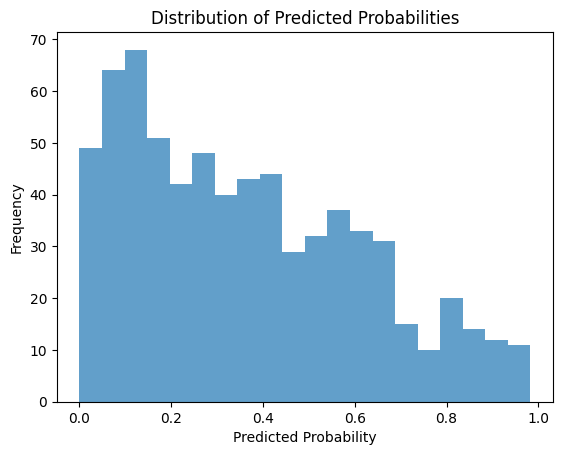

In [22]:
plt.hist(y_test_probs, bins=20, alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

Store the coeficients

In [23]:
# Reset index for consistency
extra_cols_test.reset_index(inplace=True, drop=True)

# Get coefficients and intercept
coefficients = logistic_model.coef_[0]  # Coefficients
intercept = logistic_model.intercept_[0]  # Intercept
features = X_test.columns  # Feature names

# Create the player-score DataFrame
df_a = pd.DataFrame({
    'Player': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'],
    'Score': y_test_probs,
    'Actual': y_test.reset_index(drop=True)
})

# Add feature values and calculate z (linear combination)
for i, feature in enumerate(features):
    df_a[feature] = X_test_scaled[:, i]  # Add scaled feature values
    df_a[f'Coeff_{feature}'] = coefficients[i]  # Add coefficient for each feature

# Calculate the linear combination (z) for each row
df_a['Linear_Combination'] = (
    np.dot(X_test_scaled, coefficients) + intercept
)

# Display the resulting DataFrame
print("\nPlayer, Date, Feature Contributions, Linear Combination, and Score DataFrame:")
df_a.head()



Player, Date, Feature Contributions, Linear Combination, and Score DataFrame:


,Player,Date,Score,Actual,TD-1,Coeff_TD-1,>19.8-1,Coeff_>19.8-1,>25-1,Coeff_>25-1,...,Coeff_>19.8-21,>25-21,Coeff_>25-21,ACC-21,Coeff_ACC-21,DEC-21,Coeff_DEC-21,Sprints-21,Coeff_Sprints-21,Linear_Combination
0,23085,2023-05-10,0.125882,0,0.000000,4.143936,0.000000,-5.221716,0.000000,-2.872817,...,-6.05429,0.000000,4.038792,0.075881,3.736557,0.059365,1.489683,0.017073,-3.802319,-1.937868
1,87583,2023-05-10,0.094288,0,0.000000,4.143936,0.000000,-5.221716,0.000000,-2.872817,...,-6.05429,0.000000,4.038792,0.063234,3.736557,0.104197,1.489683,0.036585,-3.802319,-2.262367
2,89871,2023-05-09,0.116115,0,0.000000,4.143936,0.000000,-5.221716,0.000000,-2.872817,...,-6.05429,0.127929,4.038792,0.249322,3.736557,0.214944,1.489683,0.024390,-3.802319,-2.029744
3,48692,2023-05-08,0.391924,0,0.230309,4.143936,0.031915,-5.221716,0.036474,-2.872817,...,-6.05429,0.140581,4.038792,0.606143,3.736557,0.520983,1.489683,0.407317,-3.802319,-0.439231
4,74154,2023-05-08,0.473360,0,0.195411,4.143936,0.028369,-5.221716,0.000000,-2.872817,...,-6.05429,0.123243,4.038792,0.404697,3.736557,0.525077,1.489683,0.031707,-3.802319,-0.106661


Find the features that affect the injuries the most

In [24]:
# Assuming your features are in a DataFrame
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,  # Replace with your feature names
    "Importance": logistic_model.coef_[0]  # Coefficients from logistic regression
})

# Sort by importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display the feature importance
print(feature_importance)

       Feature  Importance
0         TD-1    4.143936
20      >25-21    4.038792
17   Sprints-7    3.822244
21      ACC-21    3.736557
4        DEC-1    3.708753
14       >25-7    2.079447
22      DEC-21    1.489683
12        TD-7    1.248042
16       DEC-7    1.140332
6         TD-3    1.000753
15       ACC-7    0.673602
5    Sprints-1    0.478154
13     >19.8-7    0.280268
18       TD-21    0.219190
11   Sprints-3   -0.443783
8        >25-3   -0.752630
10       DEC-3   -1.834909
7      >19.8-3   -1.854263
9        ACC-3   -2.758051
2        >25-1   -2.872817
3        ACC-1   -2.888142
23  Sprints-21   -3.802319
1      >19.8-1   -5.221716
19    >19.8-21   -6.054290


Select X quantity of the top features and retrain the model

In [45]:
# Extract top features by absolute importance
num_top_features =  10 # Adjust this to include the number of features you want
top_features = feature_importance.iloc[:num_top_features]["Feature"].values

print(f"Selected Top {num_top_features} Features: {top_features}")

Selected Top 10 Features: ['>25-21' 'Sprints-7' 'TD-1' 'DEC-1' 'ACC-21' 'ACC-7' 'TD-3' 'TD-7'
 '>19.8-3' 'DEC-21']


In [46]:
# Filter the training and testing data for top features
X_train_top = X_train_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]
X_test_top = X_test_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]

# Train logistic regression with top features
logistic_model_top = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logistic_model_top.fit(X_train_top, y_train)

# Predictions
y_test_pred_top = logistic_model_top.predict(X_test_top)

# Evaluate performance
print("Updated Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_top))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_top))
print("Classification Report:\n", classification_report(y_test, y_test_pred_top))

Updated Model Evaluation:
Accuracy: 0.5734870317002881
Confusion Matrix:
 [[394 293]
 [  3   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.57      0.73       687
           1       0.01      0.57      0.03         7

    accuracy                           0.57       694
   macro avg       0.50      0.57      0.38       694
weighted avg       0.98      0.57      0.72       694



Optimal Threshold: 0.34

Evaluation with Optimal Threshold:
Accuracy: 0.3760806916426513
Confusion Matrix:
 [[254 433]
 [  0   7]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.37      0.54       687
           1       0.02      1.00      0.03         7

    accuracy                           0.38       694
   macro avg       0.51      0.68      0.29       694
weighted avg       0.99      0.38      0.53       694



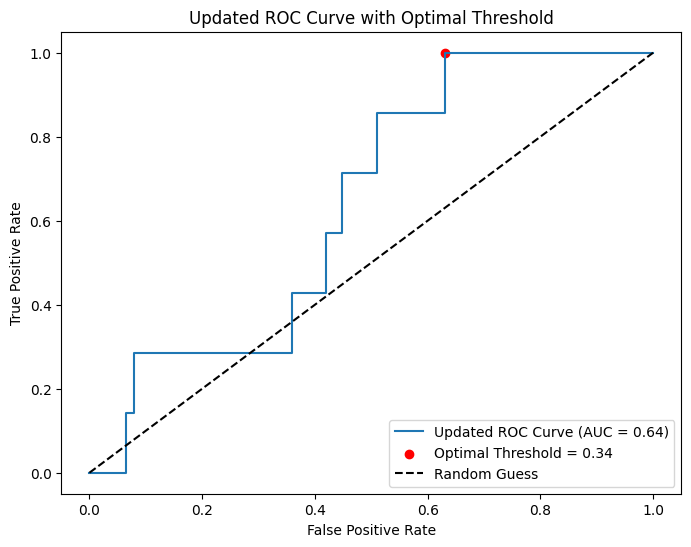

In [47]:
# Get probabilities for the updated model
y_test_probs_top = logistic_model_top.predict_proba(X_test_top)[:, 1]

# Calculate ROC curve and AUC
fpr_top, tpr_top, thresholds = roc_curve(y_test, y_test_probs_top)
roc_auc_top = auc(fpr_top, tpr_top)

# Find the optimal threshold (maximize TPR - FPR)
optimal_idx = (tpr_top - fpr_top).argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Apply the optimal threshold to make predictions
y_test_pred_optimal = (y_test_probs_top >= optimal_threshold).astype(int)

# Evaluate performance with the optimal threshold
print("\nEvaluation with Optimal Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_optimal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_optimal))
print("Classification Report:\n", classification_report(y_test, y_test_pred_optimal))

# Plot ROC curve with the optimal threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr_top, tpr_top, label=f"Updated ROC Curve (AUC = {roc_auc_top:.2f})")
plt.scatter(fpr_top[optimal_idx], tpr_top[optimal_idx], color='red', label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Updated ROC Curve with Optimal Threshold")
plt.legend(loc="lower right")
plt.show()

## SVM

SVM & GridSearch

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf', 'poly'],
    'class_weight': ['balanced', {0: 1, 1: 10}]
}

# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
grid_search.fit(X_resampled, y_resampled)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

# Use the best estimator for testing
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

SVM with manually selecting the parameters

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.63      0.77       878
           1       0.00      0.00      0.00         4

    accuracy                           0.63       882
   macro avg       0.50      0.32      0.39       882
weighted avg       0.99      0.63      0.77       882

Test Set AUC: 0.3670273348519362


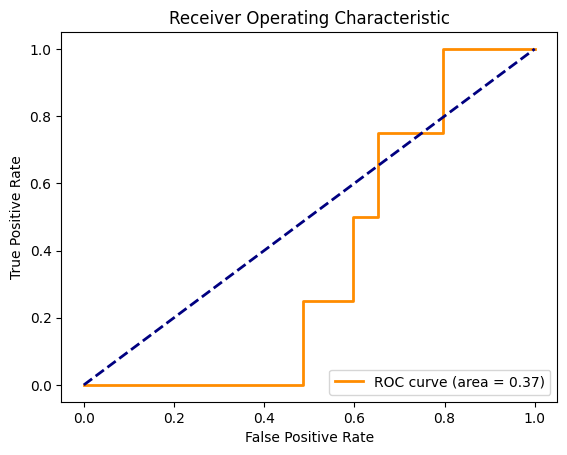

In [352]:
# Standardize the features
scaler = MinMaxScaler()
X_train_val_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train)

# # SMOTE for oversampling the training data
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train_val_scaled, y_train_val)

# Train the SVM model
svm_model = SVC(kernel='rbf', class_weight="balanced", gamma='auto',probability=True, random_state=42)
svm_model.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred = svm_model.predict(X_test_scaled)
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

# Plot ROC Curve (optional)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## XGBoost Model

### Perform Recursive Feature Elimination with Cross-Validation (RFECV) to find the best variables

In [213]:
# Base parameters for XGBClassifier
base_params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.8,  # Feature subsampling
    'subsample': 0.8,         # Row subsampling
    'eval_metric': 'auc',
    'alpha': 5,              # L1 regularization
    'gamma': 5,              # Minimum loss reduction
    'max_depth': 3,
    'learning_rate': 0.09,
    'n_estimators': 100
}

# Initialize the XGBClassifier
rfe_model = XGBClassifier(**base_params)

# Perform RFE for feature selection
rfe = RFE(
    estimator=rfe_model,
    n_features_to_select=20,  # Select exactly X features
    step=1  # Remove one feature at a time
)

# Fit RFE to X_train
rfe.fit(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[rfe.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected Features (RFE): {selected_features.tolist()}")
print(f"Number of features selected: {len(selected_features)}")

Selected Features (RFE): ['TD-1', '>19.8-1', 'ACC-1', 'DEC-1', 'Sprints-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21', 'DEC-21', 'Sprints-21']
Number of features selected: 20


### Grid Search XGBoost

In [217]:
# Updated base parameters with added regularization
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

# Expanded parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.07, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [200, 300, 400],
    'scale_pos_weight': [10,12,15],
    'alpha': [0, 1, 5],
    'gamma': [0, 1, 5],
}

# scaler = StandardScaler()
# X_train_selected = scaler.fit_transform(X_train_selected)
# X_test_selected = scaler.transform(X_test_selected)

model = XGBClassifier(**base_params_xgboost)

# Stratified K-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for ROC-AUC
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training dataset
grid_search.fit(X_train_selected, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Print best results
print(f"Best ROC-AUC (Grid Search): {best_roc_auc:.4f}")
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best ROC-AUC (Grid Search): 0.9997
Best Parameters: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400, 'scale_pos_weight': 15}


### Train the model with the best parameters

In [216]:
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

param_grid = {
   'learning_rate': 0.01,  # Explore smaller learning rates
   'max_depth': 6,             # Test broader depth values
   'n_estimators': 500,     # Include larger estimators
   'scale_pos_weight': 15,
   'alpha': 1,  # L1 regularization
   'gamma': 1,  # Minimum loss reduction
}


# Train the model with the best parameters from the grid search
# final_model = XGBClassifier(
#     **base_params_xgboost,
#     **param_grid,
# )

# Train the model with manually selected parameters
final_model = XGBClassifier(
    **base_params_xgboost,
    **param_grid,
)

# Train
final_model.fit(X_train_selected,
                y_train,
                verbose=True
)

# Predict class labels (0 or 1) on the test set
y_pred_probs = final_model.predict_proba(X_test_selected)[:, 1]
# Apply custom threshold
threshold = 0.50
y_pred = (y_pred_probs >= threshold).astype(int)
test_roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test ROC-AUC: {test_roc_auc:.4f}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Final Test ROC-AUC: 0.5144
Accuracy: 0.7814
Precision: 0.0309
Recall: 0.2667
F1 Score: 0.0554
Confusion Matrix:
[[968 251]
 [ 22   8]]


### Prepare the data to export in excel

In [53]:
X_test = X_test_selected.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
extra_cols_test = extra_cols_test.reset_index(drop=True)

Categorize the percentages into levels of risk

In [ ]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'

Create a df to later convert to excel and export

In [56]:
# Evaluate the best model on the test set
y_probs = final_model.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_probs)

print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Convert the probabilities of injury risk (Class 1) to percentages
injury_risk_percentage = y_probs * 100

# Categorize the injury risk percentages
risk_levels = [categorize_risk(percentage) for percentage in injury_risk_percentage]

# Create the `results` DataFrame with only relevant metrics and calculated values
results = pd.DataFrame({
    'Player_ID': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'], # Add player IDs
    'Actual_Label': y_test,  # Add actual labels
    '%': injury_risk_percentage,
    'Risk_Level': risk_levels
}).join(X_test[['TD-7', '>25-7', 'ACC-7', 'DEC-7', 'Sprints-7']])  # Add only relevant metrics

Test ROC-AUC: 0.7844


In [207]:
# Define risk level colors
color_mapping = {
    'High Risk': 'FF9999',  # Light Red
    'Medium Risk': 'FFFF99',  # Light Yellow
    'Low Risk': '99FF99'  # Light Green
}

# file_path_export = '/content/drive/MyDrive/WATFORD FC/Datos GPS/results.xlsx'
file_path_export = 'results.xlsx'

wb = Workbook()

# Write `results` to the first sheet
ws = wb.active
ws.title = "Injury Risk Results"
for r_idx, row in enumerate(dataframe_to_rows(results, index=True, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

# Conditional formatting for `results`
risk_level_col_idx = list(results.columns).index("Risk_Level") + 2
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=risk_level_col_idx, max_col=risk_level_col_idx):
    for cell in row:
        risk_level = cell.value
        if risk_level in color_mapping:
            cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# Save the workbook
wb.save(file_path_export)

## Mutual Info Regression formula (excluded for now)

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def mrmr_manual_regression(X, y, num_features):
    selected_features = []
    remaining_features = list(range(X.shape[1]))
    
    # Calculate mutual information for relevance (regression)
    relevance = mutual_info_regression(X, y)
    
    for _ in range(num_features):
        scores = []
        for feature in remaining_features:
            # Calculate redundancy with already selected features
            redundancy = np.mean([mutual_info_regression(X[:, feature].reshape(-1, 1), X[:, sel]) 
                                  for sel in selected_features]) if selected_features else 0
            
            # mRMR score = relevance - redundancy
            score = relevance[feature] - redundancy
            scores.append((feature, score))
        
        # Select the feature with the maximum score
        best_feature = max(scores, key=lambda x: x[1])[0]
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    
    return selected_features

selected_features_indexes = mrmr_manual_regression(X.values, y.values, 8)

feature_names = X.columns  # Assuming X is a pandas DataFrame
selected_feature_names = [feature_names[i] for i in selected_features_indexes]

print("Selected Features:", selected_feature_names)

X = X[selected_feature_names]